In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat


# carregar arquivo .mat
mat = loadmat('in_out_SBRT2_direto.mat')

in_data_ext = mat['in_extraction']
out_data_ext = mat['out_extraction']
in_data_val = mat['in_validation']
out_data_val = mat['out_validation']


lista = [in_data_ext, out_data_ext, in_data_val, out_data_val]

modulos = []
for i in lista:
    modulos.append(max(i.imag))
    modulos.append(max(i.real))

maior_modulo = max(modulos)

in_ext_norm  = in_data_ext / maior_modulo
out_ext_norm = out_data_ext /maior_modulo
in_val_norm  = in_data_val/maior_modulo
out_val_norm = out_data_val/maior_modulo

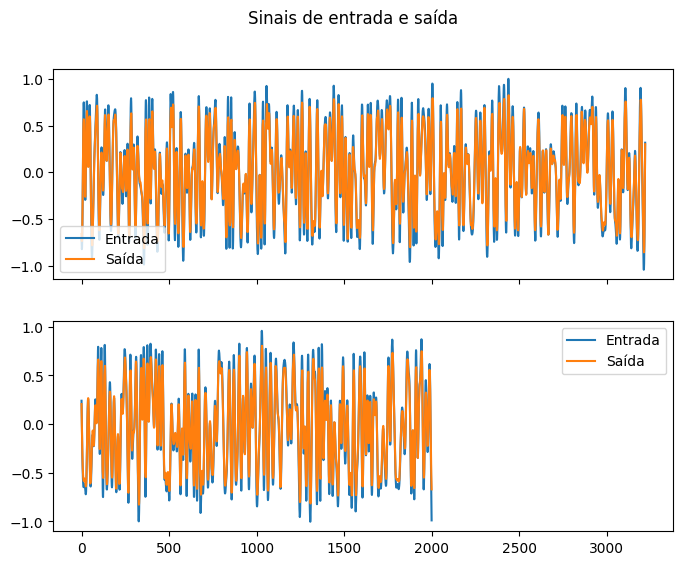

In [13]:
# plotar sinais de entrada e saída
x_ext = range(len(in_data_ext))
x_val = range(len(in_data_val))

fig, axs = plt.subplots(2, sharex=True, figsize=(8, 6))
fig.suptitle('Sinais de entrada e saída')
axs[0].plot(x_ext, np.real(in_ext_norm), label='Entrada')
axs[0].plot(x_ext, np.real(out_ext_norm), label='Saída')
axs[0].legend()
axs[1].plot(x_val, np.real(in_val_norm), label='Entrada')
axs[1].plot(x_val, np.real(out_val_norm), label='Saída')
axs[1].legend()
plt.show()

In [14]:
def mp(P, M, xn):
    L = xn.shape
    XX = np.zeros((L[0] - M, P * (M+1)), dtype=np.complex128)
    for l in range(M+1, L[0]):
        for p in range(1, P+1):
            for m in range(0, M+1):
                XX[l-M-1, ((p-1)*(M+1))+m] = (np.abs(xn[l-m])**(2*p-2)*(xn[l-m]))[0]
    return XX


def readeq(val, precision):
    return np.floor(val / (2 ** precision))

def mp_int(P, M, xn, bits):
    L = xn.shape
    XX = np.zeros((L[0] - M, P * (M+1)), dtype=np.complex128)
    for l in range(M+1, L[0]):
        for p in range(1, P+1):
            for m in range(0, M+1):
                    pot = int(2*p-2) 
                    A = np.real(xn[l-m])[0]
                    B = np.imag(xn[l-m])[0]
                    modulo_power = 2**bits 
                    modulo_square = readeq(A ** 2 + B ** 2, bits)
                    for _ in range(1, pot):
                       modulo_power = readeq(modulo_power * modulo_square, bits)
                    real_part = readeq(A * modulo_power,bits)
                    imag_part = readeq(B * modulo_power,bits)
                    XX[l-M-1, ((p-1)*(M+1))+m] = complex(real_part,imag_part)        
    return XX

def MultiplicadorMatrizes(coefficients, XX, precision):
    max_value = 0  
    result = np.zeros_like(XX, dtype=np.complex128)
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            
            A = np.real(coefficients[j,0])
            B = np.imag(coefficients[j,0])
            C = np.real(XX[i, j])
            D = np.imag(XX[i, j])

            readequated_real = readeq(A*C, precision)  +  readeq(-B * D, precision)
            readequated_imag = readeq(A*D , precision) +  readeq(B*C, precision)

            max_value = max(max_value, readequated_real)
            max_value = max(max_value, readequated_imag)
            
            result[i, j] = complex(readequated_real, readequated_imag) 

    soma_filas = np.sum(result, axis=1).reshape(-1, 1)

    extra_bits = np.ceil(np.log2(max_value + 1))
    
    return soma_filas, extra_bits



In [15]:
def mp(P, M, xn):
    L = xn.shape
    XX = np.zeros((L[0] - M, P * (M+1)), dtype=np.complex128)
    for l in range(M+1, L[0]):
        for p in range(1, P+1):
            for m in range(0, M+1):
                XX[l-M-1, ((p-1)*(M+1))+m] = (np.abs(xn[l-m])**(2*p-2)*(xn[l-m]))[0]
    return XX

def readeq(val, precision):
    return np.floor(val / (2 ** precision))

def mp_int(P, M, xn, bits):
    L = xn.shape
    XX = np.zeros((L[0] - M, P * (M+1)), dtype=np.complex128)
    for l in range(M+1, L[0]):
        for p in range(1, P+1):
            for m in range(0, M+1):
                    A = np.real(xn[l-m])[0]
                    B = np.imag(xn[l-m])[0]
                    modulo_power = 2**bits 
                    modulo_square = readeq(A ** 2 + B ** 2, bits)
                    for _ in range(1, p):
                       modulo_power = readeq(modulo_power * modulo_square, bits)
                    real_part = readeq(A * modulo_power,bits)
                    imag_part = readeq(B * modulo_power,bits)
                    XX[l-M-1, ((p-1)*(M+1))+m] = complex(real_part,imag_part)        
    return XX

def MultiplicadorMatrizes(coefficients, XX, precision):
    max_value = 0  
    coefficients = np.round(coefficients *(2**precision))
    result = np.zeros_like(XX, dtype=np.complex128)
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            
            A = np.real(coefficients[j,0])
            B = np.imag(coefficients[j,0])
            C = np.real(XX[i, j])
            D = np.imag(XX[i, j])

            readequated_real = readeq(A * C - B * D, precision)
            readequated_imag = readeq(A * D + B * C, precision)

            max_value = max(max_value, readequated_real)
            max_value = max(max_value, readequated_imag)
            
            result[i, j] = complex(readequated_real, readequated_imag) 

    soma_filas = np.sum(result, axis=1).reshape(-1, 1)

    extra_bits = np.ceil(np.log2(max_value + 1))
    
    return soma_filas, extra_bits

In [16]:
p_bits = 10
in_val_fixed = np.round(in_val_norm * (2 ** p_bits)) 
out_val_fixed = np.round(out_val_norm * (2 ** p_bits))
P = 2
M = 1
resp = np.round(mp(P, M, in_val_norm) *  (2 ** p_bits)) - mp_int(P, M, in_val_fixed, p_bits)

In [17]:
p_bits = 50
XX_val = mp_int(P, M, in_val_fixed, p_bits)
XX_ext_norm = mp(P, M, in_ext_norm)
coefficients, _, _, _ = np.linalg.lstsq(XX_ext_norm, out_ext_norm[M:], rcond=None)
predicted_val_fixed, e_bits = MultiplicadorMatrizes(coefficients, XX_val, p_bits)
resp2 = predicted_val_fixed - XX_val @ coefficients

In [18]:
P = 2
M = 1

XX_ext_norm = mp(P, M, in_ext_norm)
coefficients, _, _, _ = np.linalg.lstsq(XX_ext_norm, out_ext_norm[M:], rcond=None)

bits_precisao = [2,4,6,8,10, 11, 12]
nmse_values = []

for p_bits in bits_precisao:
    print(f'{np.round(coefficients * (2 ** p_bits))}')
    in_val_fixed = np.round(in_val_norm * (2 ** p_bits)) 
    out_val_fixed = np.round(out_val_norm * (2 ** p_bits))
    in_ext_fixed = np.round(in_ext_norm * (2 ** p_bits)) 
    out_ext_fixed = np.round(out_ext_norm * (2 ** p_bits))

    XX_val = mp_int(P, M, in_val_fixed, p_bits)

    #predicted_val_fixed = XX_val @ coefficients
    predicted_val_fixed, e_bits = MultiplicadorMatrizes(coefficients, XX_val, p_bits)
    nmse_fixed = 10 * np.log10(np.mean(np.abs(out_val_fixed[M:] - predicted_val_fixed) ** 2) / np.mean(np.abs(out_val_fixed[M:]) ** 2))

    # Levar em consideração os bits extras para evitar overflow
    total_bits = p_bits + 1 + e_bits
    nmse_values.append((p_bits,e_bits, total_bits, nmse_fixed))

for p_bits,e_bits, total_bits, nmse in nmse_values:
    print(f"Bits de precisão: {p_bits},\t  Bits de overflow: {e_bits},\t Bits total: {total_bits},\t NMSE: {nmse} dB")

[[ 1.+0.j]
 [ 3.-1.j]
 [-1.-0.j]
 [ 0.+0.j]]
[[ 2.+2.j]
 [14.-2.j]
 [-5.-1.j]
 [ 2.+2.j]]
[[  9.+8.j]
 [ 54.-8.j]
 [-22.-4.j]
 [  7.+7.j]]
[[ 36.+30.j]
 [216.-33.j]
 [-87.-18.j]
 [ 27.+28.j]]
[[ 143.+122.j]
 [ 864.-133.j]
 [-347. -72.j]
 [ 108.+113.j]]
[[ 287.+243.j]
 [1729.-265.j]
 [-695.-143.j]
 [ 216.+226.j]]
[[  573.+487.j]
 [ 3458.-531.j]
 [-1390.-287.j]
 [  432.+453.j]]
Bits de precisão: 2,	  Bits de overflow: 2.0,	 Bits total: 5.0,	 NMSE: -2.5490972473152986 dB
Bits de precisão: 4,	  Bits de overflow: 4.0,	 Bits total: 9.0,	 NMSE: -10.74482612734604 dB
Bits de precisão: 6,	  Bits de overflow: 6.0,	 Bits total: 13.0,	 NMSE: -19.948896715424144 dB
Bits de precisão: 8,	  Bits de overflow: 8.0,	 Bits total: 17.0,	 NMSE: -23.324498681171587 dB
Bits de precisão: 10,	  Bits de overflow: 10.0,	 Bits total: 21.0,	 NMSE: -23.561224007021284 dB
Bits de precisão: 11,	  Bits de overflow: 11.0,	 Bits total: 23.0,	 NMSE: -23.567886570538178 dB
Bits de precisão: 12,	  Bits de overflow: 12.0,	 B

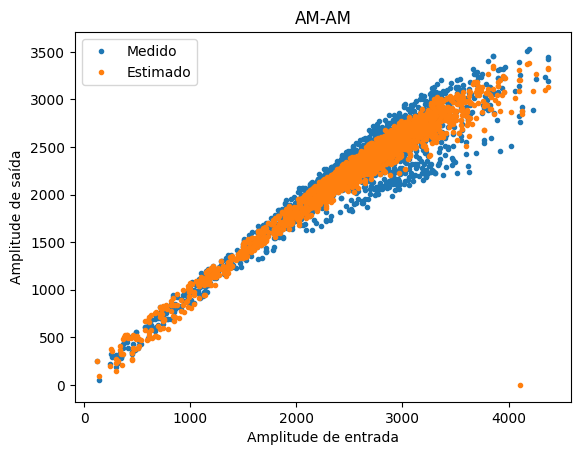

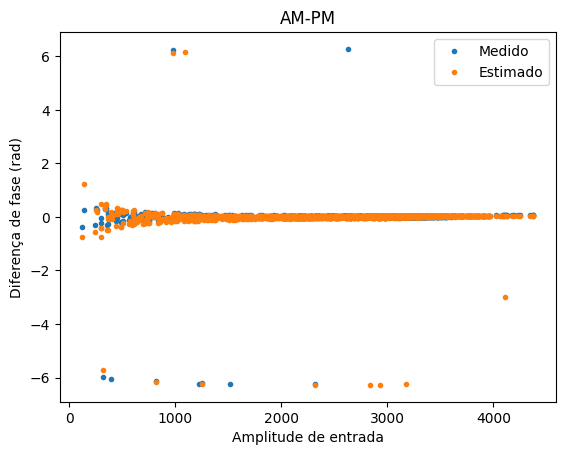

In [19]:
# Gráficos AM-AM e AM-PM
plt.figure()
plt.plot(np.abs(in_val_fixed[M:]), np.abs(out_val_fixed[M:]), '.', label='Medido')
plt.plot(np.abs(in_val_fixed[M:]), np.abs(predicted_val_fixed), '.', label='Estimado')
plt.xlabel('Amplitude de entrada')
plt.ylabel('Amplitude de saída')
plt.title('AM-AM')
plt.legend()

plt.figure()
plt.plot(np.abs(in_val_fixed[M:]), np.angle(out_val_fixed[M:])-np.angle(in_val_fixed[M:]), '.', label='Medido')
plt.plot(np.abs(in_val_fixed[M:]), np.angle(predicted_val_fixed)-np.angle(in_val_fixed[M:]), '.', label='Estimado')
plt.xlabel('Amplitude de entrada')
plt.ylabel('Diferença de fase (rad)')
plt.title('AM-PM')
plt.legend()
plt.show()